In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing

%matplotlib inline

2024-02-28 15:35:22.922007: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 15:35:23.869408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 15:35:23.869430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 15:35:23.872415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 15:35:24.348489: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 15:35:24.350521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/swat_processed_sample.csv", sep=",", usecols=range(1,23), skiprows=[0])

In [3]:
attacks = preprocessing.normalize(attacks.to_numpy(), norm="max", axis=0)

# swap sport to front
attacks[:, [0, 1]] = attacks[:, [1, 0]]
# swap dport to after sport
attacks[:, [1, 2]] = attacks[:, [2, 1]]
# swap protocols to after dport
attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)



# should probably add batch and shuffle

train_dataset = attacks[:int(np.floor(attacks.shape[0]*3/4))]
test_dataset = attacks[int(np.floor(attacks.shape[0]*3/4)):]

num_features = attacks[:int(np.floor(attacks.shape[0]*3/4))].shape[1]
seq_length = 5

In [ ]:
len(train_dataset), len(test_dataset)

(1500, 500)

In [ ]:
train_dataset[2]

array([7.27481853e-01, 7.99678830e-01, 2.50000000e-01, 1.33689840e-03,
       2.29095074e-03, 1.30282912e-03, 1.94383728e-03, 5.15252969e-04,
       1.34779820e-04, 5.58035706e-04, 1.02306549e-03, 1.52555301e-03,
       7.65110941e-04, 4.49197871e-01, 2.15040043e-03, 2.15040043e-03,
       0.00000000e+00, 2.15040043e-03, 2.15040043e-03, 2.15040043e-03,
       0.00000000e+00, 2.15040043e-03])

In [ ]:
train_dataset[3]

array([5.53460684e-01, 6.60183781e-04, 2.50000000e-01, 2.67379679e-03,
       1.90912562e-03, 5.24761820e-03, 5.48529191e-03, 5.84350684e-05,
       1.01134633e-05, 3.20936160e-05, 2.22186570e-05, 2.28832952e-03,
       3.06044376e-03, 7.43833008e-01, 8.10130162e-02, 8.10130162e-02,
       0.00000000e+00, 8.10130162e-02, 8.10130162e-02, 8.10130162e-02,
       0.00000000e+00, 8.10130162e-02])

In [ ]:
# custom loss
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

In [ ]:
# clip model weights to a given hypercube
class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [ ]:
# Wasserstein loss for critic
def critic_loss(pred_real, pred_fake):
    return tf.keras.backend.mean(pred_real * pred_fake)

# Wasserstein loss for generator
def generator_loss(pred_fake):
    return -tf.keras.backend.mean(pred_fake)

In [ ]:
generator_optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00005)
critic_optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00005)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, _data, num_classes_list):
        self.data = torch.tensor(_data, dtype=torch.float32)
        self.num_classes_list = num_classes_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # One-hot encode each of the first three values with different num_classes
        one_hot_encoded_1 = torch.nn.functional.one_hot(sample[0].long(), self.num_classes_list[0])
        one_hot_encoded_2 = torch.nn.functional.one_hot(sample[1].long(), self.num_classes_list[1])
        one_hot_encoded_3 = torch.nn.functional.one_hot(sample[2].long(), self.num_classes_list[2])
        # print("1 :",one_hot_encoded_1.shape)
        # print("2 :",one_hot_encoded_2.shape)
        # print("3 :",one_hot_encoded_3.shape)
        # print("4 :",sample[3:].shape)
        # Concatenate one-hot encoding with the remaining values
        modified_sample = torch.cat((one_hot_encoded_1.float(), one_hot_encoded_2.float(), one_hot_encoded_3.float(), sample[3:]))

        return modified_sample

data = np.array(train_dataset[:10000])
dataset = Dataset(data,[23030, 14372, 7])

batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)


In [9]:
def differentiable_argmax(gumbel_softmax_sample):
    _, max_indices = gumbel_softmax_sample.max(dim=-1, keepdim=True)
    one_hot = torch.zeros_like(gumbel_softmax_sample).scatter_(-1, max_indices, 1.0)
    return one_hot - gumbel_softmax_sample.detach() + gumbel_softmax_sample

In [10]:
def convert_generator_output(output_tensors):
    sport_dist, dport_dist, proto_dist, cont = output_tensors
    num_samples = sport_dist.size(0)
    final = torch.zeros((num_samples, 22))

    for sample_index in range(num_samples):
        sport = torch.argmax(sport_dist[sample_index]) + 1
        dport = torch.argmax(dport_dist[sample_index]) + 1
        proto = torch.argmax(proto_dist[sample_index]) + 1

        data_point = torch.cat((sport.view(1), dport.view(1), proto.view(1), cont[sample_index]))
        final[sample_index] = data_point

    return final

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Gumbel
num_features=22
# Generator model

class Generator(nn.Module):
    def __init__(self, input_dim, num_features):
        super(Generator, self).__init__()

        self.hidden1 = nn.Linear(input_dim, 80)
        self.hidden2 = nn.Linear(80, 80)

        self.sport_hidden = nn.Linear(10, 23030)
        self.dport_hidden = nn.Linear(10, 14372)
        self.proto_hidden = nn.Linear(10, 7)

        # self.sport_output = nn.Softmax(dim=1)
        # self.dport_output = nn.Softmax(dim=1)
        # self.proto_output = nn.Softmax(dim=1)

        self.cont_output = nn.Linear(50, num_features - 3)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        # print(x.shape)
        _sport_hidden = self.sport_hidden(x[:,:10])
        _dport_hidden = self.dport_hidden(x[:,10:20])

        _proto_hidden = self.proto_hidden(x[:,20:30])
        # sport_output = self.sport_output(sport_hidden)
        # dport_output = self.dport_output(dport_hidden)
        # proto_output = self.proto_output(proto_hidden)

        # Do not apply torch.argmax here, let the loss function handle it
        cont_output = self.cont_output(x[:,30:])

        # Concatenate the tensors along dimension 1
        output_tensor = torch.cat((_sport_hidden, _dport_hidden, _proto_hidden, cont_output), dim=1)
        return output_tensor
        # return sport_output, dport_output, proto_output, cont_output
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size=100, recurrent_dropout=0.4):
        super(Discriminator, self).__init__()

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True, dropout=recurrent_dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True, dropout=recurrent_dropout)

        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * 2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size * 2)

        # Linear output layer
        self.output_layer = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm1(x)
        # print(out.shape)
        out = self.batch_norm1(out)
        # print(out.shape)
        out, _ = self.lstm2(out)
        # print(out.shape)
        out = self.batch_norm2(out)
        # print(out.shape)

        # Global average pooling
        # out = torch.mean(out, dim=1)
        # print(out.shape)
        # Output layer
        # out = self.output_layer(out)
        out = torch.sigmoid(self.output_layer(out))


        return out  # Fix for the dimension mismatch

# Hyperparameters
latent_dim = 100
data_dim = len(dataset[1])
lr = 0.00002
batch_size = 64
epochs = 10

# Models
generator = Generator(latent_dim, num_features)
discriminator = Discriminator(data_dim)
max_grad_norm = 1.0
# Loss function and optimizers
criterion = nn.BCELoss()
criterion_gen = nn.SmoothL1Loss()
# criterion = nn.CrossEntropyLoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
import csv
import copy
from tqdm import tqdm
parameters_list = []
dlosses = []
glosses = []

generator.train()
discriminator.train()
for epoch in tqdm(range(epochs)):
    total_loss_fake = 0
    total_loss_real = 0
    total_loss_gen = 0
    for _ in data_loader:
        # Train Discriminator
        real_data = _
        real_labels = torch.ones((batch_size, 1))
        fake_labels = torch.zeros((batch_size, 1))

        optimizer_d.zero_grad()

        # Real data
        # print("Real data: ", real_data.shape)
        output_real = discriminator(real_data)
        # print(output_real)
        loss_real = criterion(output_real, real_labels)
        # print("Loss:", loss_real.item())
        loss_real.backward()
        # print("Gradients of a specific layer:", generator.hidden1.weight.grad)
        total_loss_real+=loss_real

        # Fake data
        noise = torch.randn(batch_size, latent_dim)
        output = generator(noise)

        sport_output = F.softmax(output[:, :23030], dim=1)
        dport_output = F.softmax(output[:, 23030:23030+14372], dim=1)
        proto_output = F.softmax(output[:, 23030+14372:23030+14372+7], dim=1)
        cont_output = output[:, 23030+14372+7:]

        fake_data = torch.cat((sport_output, dport_output, proto_output, cont_output), dim=1)

        output_fake = discriminator(fake_data)
        # print(output_fake)
        # print(fake_labels)
        loss_fake = criterion(output_fake, fake_labels)
        loss_fake.backward()
        total_loss_fake+=loss_fake
        # print("Gradients of a specific layer:", generator.hidden1.weight.grad)
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        # generated_data = generator(noise)
        output = generator(noise)
        # print(fake_data.shape)
        sport_output = F.softmax(output[:, :23030], dim=1)
        dport_output = F.softmax(output[:, 23030:23030+14372], dim=1)
        proto_output = F.softmax(output[:, 23030+14372:23030+14372+7], dim=1)
        # sport_hidden = output[:, :23030]
        # dport_hidden = output[:, 23030:23030+14372]
        # proto_hidden = output[:, 23030+14372:23030+14372+7]
        cont_output = output[:, 23030+14372+7:]
        # temperature = 1.0  # You can adjust the temperature hyperparameter
        # gumbel_dist = Gumbel(0, 1).sample(sport_hidden.shape)
        # sport_output = F.softmax((sport_hidden + gumbel_dist) / temperature, dim=1)

        # gumbel_dist = Gumbel(0, 1).sample(dport_hidden.shape)
        # dport_output = F.softmax((dport_hidden + gumbel_dist) / temperature, dim=1)

        # gumbel_dist = Gumbel(0, 1).sample(proto_hidden.shape)
        # proto_output = F.softmax((proto_hidden + gumbel_dist) / temperature, dim=1)
        # print(proto_output.shape)
        # print(proto_output)
        # print(differentiable_argmax(proto_output))
        # print(differentiable_argmax(proto_output)[:,1])

        # print(cont_output.shape)

        # generated_data = torch.cat((differentiable_argmax(sport_output).unsqueeze(1),differentiable_argmax(dport_output)[:,1].unsqueeze(1),differentiable_argmax(proto_output)[:,1].unsqueeze(1), cont_output), dim=1)
        # generated_data = torch.cat((sport_output[:,1].unsqueeze(1),dport_output[:,2].unsqueeze(1),proto_output[:,3].unsqueeze(1),cont_output), dim=1)
        generated_data = torch.cat((sport_output, dport_output, proto_output, cont_output), dim=1)
        # print(generated_data.shape)


        # generated_data = convert_generator_output(generator(noise))
        # print(generated_data.shape)
        output_generated = discriminator(generated_data)
        # loss_gen = criterion(output_generated, real_labels)
        loss_gen = criterion_gen(output_generated, real_labels.float())
        # print("Discriminator Output:", output_generated)
        # print("Real Labels:", real_labels)
        # print("Loss:", loss_gen.item())
        loss_gen.backward()
        # torch.nn.utils.clip_grad_norm_([generator.sport_hidden.weight], max_grad_norm)
        total_loss_gen+=loss_gen
        # for param in generator.sport_hidden.parameters():
        #   print(param.requires_grad)
        # for name, param in generator.named_parameters():
        #   if name == 'sport_hidden.weight':
        #       print(name, param.requires_grad)
        #       print(name, param.grad)
        #       print(f"{name} - Gradient Statistics: Mean={param.grad.mean()}, Std={param.grad.std()}, Min={param.grad.min()}, Max={param.grad.max()}")

        # asdasdasd
        # print("Gradients of a specific layer:", generator.sport_hidden.weight.grad)
        optimizer_g.step()

    # Print losses at the end of each epoch
    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {total_loss_real + total_loss_fake}, G Loss: {total_loss_gen}")
    # print(f"\nEpoch {epoch + 1} - Parameters of Generator:\n")
    epoch_parameters = {"Epoch": epoch + 1}
    for name, param in generator.named_parameters():
        # print(name, param.data)
        # Store parameters in the dictionary
        # epoch_parameters[name] = param.data
        epoch_parameters[name] = copy.deepcopy(param.data)

    # Append epoch parameters to the dictionary
    parameters_list.append(epoch_parameters)
    dlosses.append(loss_real + loss_fake)
    glosses.append(loss_gen)




 10%|█         | 1/10 [00:16<02:28, 16.55s/it]

Epoch [1/10], D Loss: 33.056175231933594, G Loss: 2.850388526916504


 20%|██        | 2/10 [00:33<02:12, 16.61s/it]

Epoch [2/10], D Loss: 32.42152786254883, G Loss: 2.837352991104126


 30%|███       | 3/10 [00:49<01:56, 16.59s/it]

Epoch [3/10], D Loss: 32.24760818481445, G Loss: 2.8269238471984863


 40%|████      | 4/10 [01:06<01:40, 16.75s/it]

Epoch [4/10], D Loss: 32.20570373535156, G Loss: 2.8321399688720703


 50%|█████     | 5/10 [01:23<01:23, 16.69s/it]

Epoch [5/10], D Loss: 32.16664505004883, G Loss: 2.833932638168335


 60%|██████    | 6/10 [01:39<01:06, 16.64s/it]

Epoch [6/10], D Loss: 32.14142990112305, G Loss: 2.8404886722564697


 70%|███████   | 7/10 [01:56<00:49, 16.60s/it]

Epoch [7/10], D Loss: 32.12034225463867, G Loss: 2.8449771404266357


 80%|████████  | 8/10 [02:13<00:33, 16.60s/it]

Epoch [8/10], D Loss: 32.08780288696289, G Loss: 2.8460283279418945


 90%|█████████ | 9/10 [02:29<00:16, 16.51s/it]

Epoch [9/10], D Loss: 32.07109069824219, G Loss: 2.8494677543640137


100%|██████████| 10/10 [02:45<00:00, 16.55s/it]

Epoch [10/10], D Loss: 32.058753967285156, G Loss: 2.8543262481689453


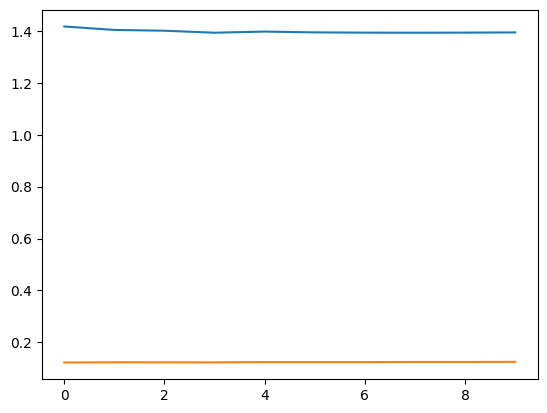

In [20]:
# dlosses = [dloss.detach().numpy() for dloss in dlosses]
# glosses = [gloss.detach().numpy() for gloss in glosses]

# plt.figure(1)
plt.plot(dlosses)
# plt.figure(2)
plt.plot(glosses)

In [ ]:
# csv_file_path = "generator_parameters_1.csv"
# with open(csv_file_path, mode='w', newline='') as csv_file:
#     fieldnames = ["Epoch"] + list(generator.state_dict().keys())
#     csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
#     print(fieldnames)
#     # Write the header
#     csv_writer.writeheader()

#     # Write parameters for each epoch
#     for i in parameters_list:
#       # print(i)
#       # for key in i.keys():
#       # print(i.values())
#       print(i.keys())
#       row = {}
#       for key in i.keys():
#         row[key] = i[key]
#       print(row.keys())
#       csv_writer.writerow(i)

#       # exit
#       # csv_writer.writerows(i.values())

In [ ]:
import tensorflow as tf
import numpy as np

# Assuming num_features is defined somewhere
num_features = 30

# Assuming wasserstein_loss is defined somewhere
def wasserstein_loss(y_true, y_pred):
    # Placeholder for wasserstein_loss function
    return tf.reduce_mean(y_true * y_pred)

def make_generator_model(input_dim):
    input = tf.keras.layers.Input(shape=input_dim, name="generator input")
    hidden = tf.keras.layers.Dense(80, activation="relu")(input)
    hidden = tf.keras.layers.Dense(80, activation="relu")(hidden)
    print(hidden.shape)
    sport_hidden = tf.keras.layers.Dense(23030, name="sport_hidden")(hidden)
    dport_hidden = tf.keras.layers.Dense(14372, name="dport_hidden")(hidden)
    proto_hidden = tf.keras.layers.Dense(7, name="proto_hidden")(hidden)
    print(hidden.shape)
    print(sport_hidden.shape)
    print(dport_hidden.shape)
    print(proto_hidden.shape)
    sport_output = tf.keras.layers.Softmax(1, name="sport_output")(sport_hidden)
    dport_output = tf.keras.layers.Softmax(1, name="dport_output")(dport_hidden)
    proto_output = tf.keras.layers.Softmax(1, name="proto_output")(proto_hidden)
    cont_output = tf.keras.layers.Dense(num_features-3, name="cont_output")(hidden)

    model = tf.keras.Model(inputs=input, outputs=[sport_output, dport_output, proto_output, cont_output],
                           name="Generator")
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    # model.compile(loss=wasserstein_loss, optimizer=opt)

    return model

# Assuming input_dim is 100 for example
input_dim = 100

# Create a random input tensor for testing
random_input = np.random.rand(1, input_dim)

# Instantiate the generator model
generator_model = make_generator_model(input_dim)

# Forward pass through the generator
output_tensors = generator_model.predict(random_input)

# Display the shapes after each step
print("Random Input Shape:", random_input.shape)
print("Hidden Layer Output Shape:", output_tensors[0].shape)
print("Sport Output Shape:", output_tensors[1].shape)
print("Dport Output Shape:", output_tensors[2].shape)
print("Proto Output Shape:", output_tensors[3].shape)
print("Continuous Output Shape:", output_tensors[4].shape)


(None, 80)
(None, 80)
(None, 23030)
(None, 14372)
(None, 7)
1/1 [==============================] - 0s 90ms/step
Random Input Shape: (1, 100)
Hidden Layer Output Shape: (1, 23030)
Sport Output Shape: (1, 14372)
Dport Output Shape: (1, 7)
Proto Output Shape: (1, 27)


IndexError: list index out of range